# Our training method

Originally, the training data was 110,000 sentences. However when training using it, memory error was occurred.
Therefore, we devided the data into six parts, and used them to train one by one.

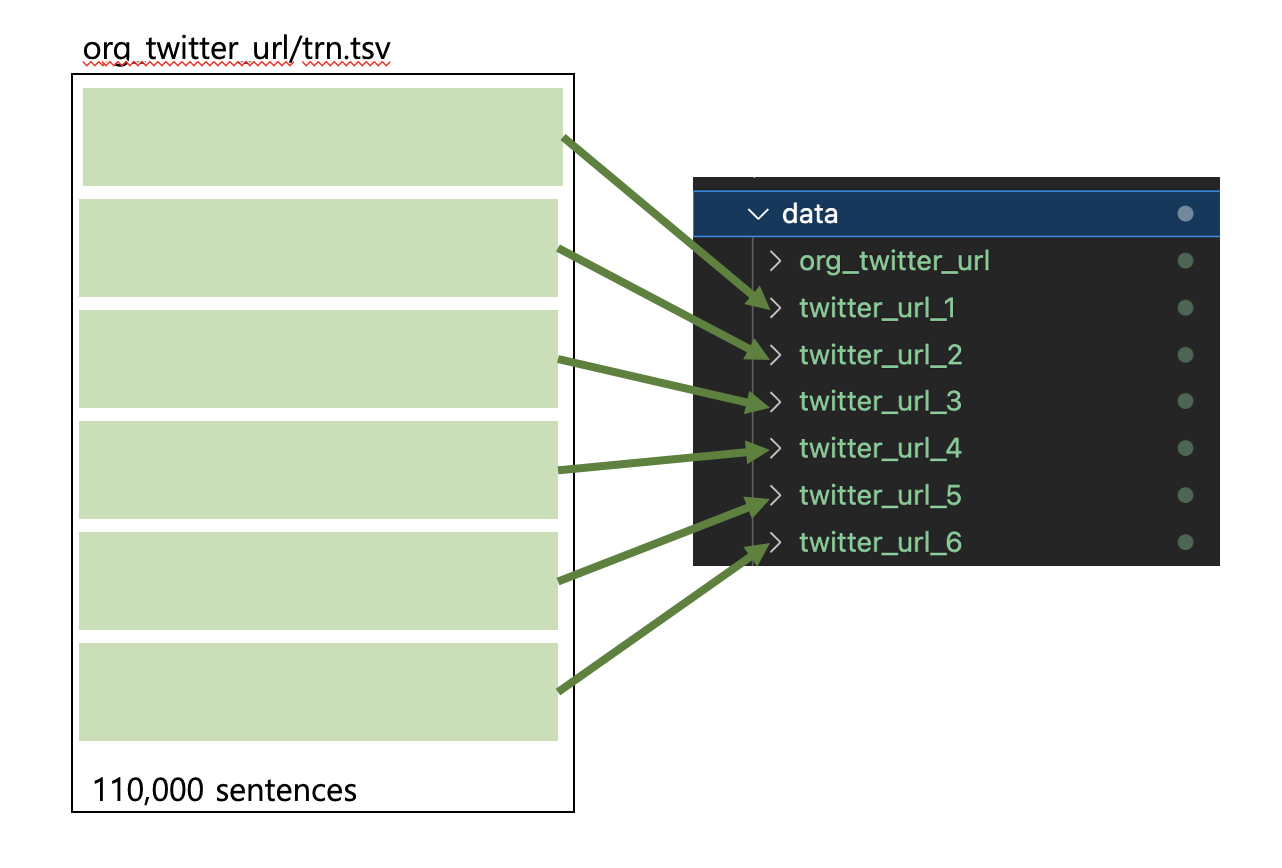

In [1]:
## own code
import sys

sys.path.append('/home/saemeechoi/smchoi/GP-VAE/models/pg')

In [2]:
## own code
import os
import argparse
import torch
import random
from torch import optim
from math import exp

from model import Copynet, Normal, MoG, Vamp, GP_Full
from training import train, evaluate
from utils import reader
from decode import BeamSearch

/home/saemeechoi/anaconda3/envs/gpvae/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
## own code
from easydict import EasyDict as edict

args = edict({'task': 'train',
             'data_file': '../../../data/twitter_url_1',
              
             # In this part, we change the data in the specific order for each epoch
             # to train one of the six parts of the data
              
             # <order of the data>
             # twitter_url_1
             # twitter_url_2
             # twitter_url_3
             # twitter_url_4
             # twitter_url_5
             # twitter_url_6
              
             'model_type': 'gp_full',
             'kernel_v': 65.0,
             'kernel_r': 0.0001,
             'epochs':1,
             'batch_size': 64,
             'optim': 2,
             'lr': 0.001,
             'grad_clip': 5.0,
             'val_step': 1,
             'print_step': 100,
              'kw': 0.,
              'x0': 25000,
              'embed_size': 300,
              'hidden_size': 512,
              'latent_size': 256,
              'word_dropout': 0,
              'embed_dropout': 0.5,
              'components': 10,
              'kld_sampled':0,
              'vocab_size': 20000,
              'max_len': 30,
              'using_cuda': True,
              'sample_num': 10,
              'beam_size': 10,
              'model_file': None,
              'topn':10,
              'std':1.,
              'decode_from': 'sample',
              'seed': 123
             })

In [4]:
## own code
GPU_NUM = 1
device = torch.device(f'cuda:{GPU_NUM}')
torch.cuda.set_device(device)

In [5]:
## own code
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [6]:
## refactoring the author's
import os
import spacy
from torchtext.data import Field, TabularDataset, BucketIterator

spacy_en = spacy.load('en_core_web_sm')

# Tokenize English sentence
def tokenize_fn(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Define field
TXT = Field(tokenize=tokenize_fn, init_token='<sos>', eos_token='<eos>', lower=True)

# Source and target both are text
fields = [("src", TXT), ("trg", TXT)]

# Create a Dataset instance 
trn_data = TabularDataset(os.path.join(args.data_file,'trn'+".tsv"), format="TSV", fields=fields, skip_header=False)
val_data = TabularDataset(os.path.join(args.data_file,'val'+".tsv"), format="TSV", fields=fields, skip_header=False)
tst_data = TabularDataset(os.path.join(args.data_file,'tst'+".tsv"), format="TSV", fields=fields, skip_header=False)

# Build vocab using training data
TXT.build_vocab(trn_data, min_freq=1, vectors="glove.6B.100d") # max_size=15000

# Create iterator
train_iter, val_iter, test_iter = BucketIterator.splits((trn_data, val_data, tst_data), 
                                                        batch_size=args.batch_size, 
                                                        sort_key=lambda x: len(x.src),
                                                        sort=True,
                                                        shuffle=False,
                                                        repeat=False)
txtfield = TXT

print("[TRAIN]:%d (dataset:%d)\t[VAL]:%d (dataset:%d)\t[TEST]:%d (dataset:%d)"
      % (len(train_iter), len(train_iter.dataset),
         len(val_iter), len(val_iter.dataset),
         len(test_iter), len(test_iter.dataset)))
print("[vocab]:%d" % (len(txtfield.vocab)))

[TRAIN]:300 (dataset:19200)	[VAL]:16 (dataset:1000)	[TEST]:47 (dataset:3000)
[vocab]:18885


In [7]:
## refactoring the author's code
from model import GP_Full


# Create model instance
model = GP_Full(args, txtfield)
model = model.cuda()

In [8]:
## refactoring the author's code
args.model_file = 'logs_twitter_url_tot/best_model.pt'

print("Loading the pretrained model from: {}".format(args.model_file))

# Load the best model weights
model.load_state_dict(torch.load(args.model_file))

Loading the pretrained model from: logs_twitter_url_tot/best_model_1.pt


<All keys matched successfully>

### 5. Set optimizer

In [9]:
## refactoring the author's code
from torch import optim


# Create optimizer instance
params = model.parameters()
optimizer = optim.Adam(params, lr=args.lr)

### 6. Train

In [10]:
## refactoring the author's code
import logging
import datetime
import tensorflow as tf
import absl.logging
from training import evaluate
logging.root.removeHandler(absl.logging._absl_handler)
absl.logging._warn_preinit_stderr = False

import torch
from torch import autograd
from torch.nn.utils import clip_grad_norm_ as clip_grad_norm
from utils import kl_anneal_weight

print("*** Training with validation ... ***")

# Check current time
curr_time = datetime.datetime.now()
time_stamp = "{}-{}-{}-{}-{}-{}".format(curr_time.year, curr_time.month, curr_time.day,
                                            curr_time.hour, curr_time.minute, curr_time.second)

# Set output directory name
data_file = args.data_file.split('/')[-1]
wpath = "logs_twitter_url_tot"
fprefix = "best_model"
if not os.path.isdir(wpath):
    os.makedirs(wpath)
flog = os.path.join(wpath, fprefix+".log")
logging.basicConfig(format='%(asctime)s %(message)s',
                    datefmt='%Y-%m-%d %I:%M:%S %p',
                    handlers=[
                        logging.FileHandler(flog), # to file
                        logging.StreamHandler() # to stdout
                    ],
                    level=logging.INFO)
logging.info("File name prefix: {}".format(fprefix))
logging.info(args)
logging.info(model)

# -----------------------------
# Create tensorboard logs
eval_log = 'tensorboard_logs_'+data_file+'/' + fprefix
if not os.path.exists(eval_log):
    os.makedirs(eval_log)
summary_writer = tf.summary.FileWriter(eval_log)

# -----------------------------
# Start training
global_step = 0
early_stop = 0
best_val_loss = 1000
for e in range(1, args.epochs+1):
    for b, batch in enumerate(train_iter):
        
        # Set model to training mode
        model.train()
        
        # Initialize gradient to zeros
        optimizer.zero_grad()
        
        # Predict and calculate losses
        nll, kld = model(batch)
        kl_weight = kl_anneal_weight(global_step, args)

        loss = nll + kl_weight * kld
        
        # Backpropagate
        loss.backward()
        
        # Clip gradient
        clip_grad_norm(model.parameters(), args.grad_clip) 
        
        # Update weight
        optimizer.step()
        global_step += 1
        
        # Print result
        if global_step % args.print_step == 0:
            logging.info("[Epoch: %d] [Batch: %d/%d] [NLL: %.4f] [KLD: %.4f]" % 
                        (e, b+1, len(train_iter), nll, kld))
            
            # Add nll, kld into tensorboard
            train_nll = tf.Summary()
            train_nll.value.add(tag='train_nll', simple_value=nll)
            summary_writer.add_summary(train_nll, global_step=global_step)
            summary_writer.flush()
            train_kld = tf.Summary()
            train_kld.value.add(tag='train_kld', simple_value=kld)
            summary_writer.add_summary(train_kld, global_step=global_step)
            summary_writer.flush()
            kld_weight = tf.Summary()
            kld_weight.value.add(tag='kld_weight', simple_value=kl_weight)
            summary_writer.add_summary(kld_weight, global_step=global_step)
            summary_writer.flush()

    # Start validation
    if e % args.val_step == 0:

        val_nll, val_kld = evaluate(model, val_iter, txtfield, args)
        logging.info("Val => [Current NLL: %5.4f] [Current KLD: %5.4f] [Best Loss: %5.4f]" 
                     % (val_nll, val_kld, best_val_loss))

        val_loss = val_nll + val_kld
        early_stop += 1
        
        # Update the best model
        if val_loss < best_val_loss:
            print("[!] saving model...")
            torch.save(model.state_dict(), os.path.join(wpath, fprefix+".pt"))
            best_val_loss = val_loss
            early_stop = 0
            
        # Add val_loss into tensorboard
        loss_sum = tf.Summary()
        loss_sum.value.add(tag='val_loss', simple_value=val_loss)
        summary_writer.add_summary(loss_sum, global_step=int(e/args.val_step))
        summary_writer.flush()


2022-12-01 04:37:20 PM File name prefix: best_model_2
2022-12-01 04:37:20 PM {'task': 'train', 'data_file': '../../../data/twitter_url_2', 'model_type': 'gp_full', 'kernel_v': 65.0, 'kernel_r': 0.0001, 'epochs': 1, 'batch_size': 64, 'optim': 2, 'lr': 0.001, 'grad_clip': 5.0, 'val_step': 1, 'print_step': 100, 'kw': 0.0, 'x0': 25000, 'embed_size': 300, 'hidden_size': 512, 'latent_size': 256, 'word_dropout': 0, 'embed_dropout': 0.5, 'components': 10, 'kld_sampled': 0, 'vocab_size': 20000, 'max_len': 30, 'using_cuda': True, 'sample_num': 10, 'beam_size': 10, 'model_file': 'logs_twitter_url_tot/best_model_1.pt', 'topn': 10, 'std': 1.0, 'decode_from': 'sample', 'seed': 123}
2022-12-01 04:37:20 PM GP_Full(
  (embedding): Embedding(20000, 300)
  (bi_lstm): LSTM(300, 512, batch_first=True, bidirectional=True)
  (hidden2latent): Linear(in_features=1024, out_features=256, bias=True)
  (latent2hidden): Linear(in_features=256, out_features=1024, bias=True)
  (reduce_h): Linear(in_features=1024, out

*** Training with validation ... ***


2022-12-01 04:37:44 PM [Epoch: 1] [Batch: 100/300] [NLL: 3.9742] [KLD: 0.0014]
2022-12-01 04:38:14 PM [Epoch: 1] [Batch: 200/300] [NLL: 4.6717] [KLD: 0.1856]
2022-12-01 04:38:52 PM [Epoch: 1] [Batch: 300/300] [NLL: 4.5800] [KLD: 0.1022]
2022-12-01 04:38:54 PM Val => [Current NLL: 4.4059] [Current KLD: 0.0733] [Best Loss: 1000.0000]


[!] saving model...
